In [12]:
import timeit
start = timeit.default_timer()

import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import sys
print(sys.version)

3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]


In [13]:
from datetime import datetime, timezone
import numpy as np
import pyarrow as pa
import geohash_tools as gh
import pyspark as ps

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
# from matplotlib import rc

In [14]:
sp = spark.read.load('hdfs://orion11:14001/nam/2019/01/05/*',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

schema = sp.schema

sp = spark.read.schema(schema).load('hdfs://orion11:14001/nam/201*/*/*/*',
                     format='csv',
                     sep='\t',
                     header='true')

In [15]:
geohash = input()
if len(geohash) > 6:
    geohash = geohash[:6]
# f43k6g

f43k6g


In [16]:
print(sp.rdd.first())

Row(1_time=1504602000000, 2_lat=58.424226538128224, 3_lon=-88.11817117586963, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=19.470325, pressure_maximum_wind=29965.646, pressure_surface=100906.21, pressure_tropopause=25109.357, relative_humidity_zerodegc_isotherm=74.0, snow_depth_surface=0.0, temperature_surface=282.89194, temperature_tropopause=217.00394, total_cloud_cover_entire_atmosphere_single_layer=100.0, total_precipitation_surface_3_hour_accumulation=0.0625, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=15.601766, _c18=None)


In [17]:
def c2f(t):
    return (t*9/5.0)+32

def k2c(t):
    return t-273.15

def k2f(t):
    return (t*9/5.0)-459.67

def disable_spines(ax):
    for s in ax.spines:
        ax.spines[s].set_visible(False)

# rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

use_c = True
converter = k2c if use_c else k2f

In [18]:
# epochs = sorted(sp.rdd.map(lambda x: x[0]).distinct().collect())

# print('# unique epochs:', len(epochs))
# print('min epoch:', min(epochs), 'max epoch:', max(epochs))
# print(epochs)

In [19]:
# epoch_deltas = {}
# for i in range(len(epochs)-1):
#     if epochs[i+1]-epochs[i] in epoch_deltas:
#         epoch_deltas[epochs[i+1]-epochs[i]] += 1
#     else:
#         epoch_deltas[epochs[i+1]-epochs[i]] = 1
# # epoch_deltas = sorted(epoch_deltas)
# print(sorted([e/60/60/1000 for e in epoch_deltas]))
# # print(epoch_deltas/(60*60*24))

In [20]:
data = sp.rdd \
    .map(lambda x: ( gh.encode(x[1], x[2]),\
                    datetime.fromtimestamp(x[0]/1000, timezone.utc).year,\
                    datetime.fromtimestamp(x[0]/1000, timezone.utc).month,\
                    converter(x[10]),\
                    x[13]*2 if use_c else x[13]*2*.0393701 ))

# x[13] rain is mm/3hr, change to in/3hr if !use_c by *.0393701

In [21]:
print(data.take(10))

[('f43k6g', 2017, 9, 9.74194, 0.125), ('c14982', 2017, 9, 15.86193000000003, 0.0), ('dr4vmp', 2017, 9, 17.49194, 0.0), ('c0d1zj', 2017, 9, 16.961940000000027, 0.0), ('9mkc6s', 2017, 9, 21.31194000000005, 0.0), ('f62wg0', 2017, 9, 9.501950000000022, 0.0), ('f1k52d', 2017, 9, 8.431939999999997, 0.0), ('9gb9wc', 2017, 9, 15.81194000000005, 0.125), ('9u53s0', 2017, 9, 30.051930000000027, 50.625), ('c0hrx2', 2017, 9, 18.011930000000007, 0.125)]


In [22]:
def shl_str_cmp(a,b):
    if len(a) >= len(b):
        return a.startswith(b)
    else:
        return b.startswith(a)

num_years = data.map(lambda x: x[1]).distinct().count()

Exception in thread "serve RDD 24" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [23]:
def min2(a,b):
    return a if a <= b else b

def max2(a,b):
    return a if a >= b else b

# data = ( geohash, year, month, temp, precip ) for every day/time point in dataset
# -> include only data from geohash entered
# -> reshape to ( month, ( 1, temp, temp, temp, precip ) )
# -> sort and reduce to ( month, ( n, sum_temp, min_temp, max_temp, sum_precip ) )
# -> reshape to ( month, min_temp, avg_temp, max_temp, avg_precip )

# Note: temp is daily avg, precip is avg total monthly accumulation

#monthly weather data
mwd = data \
    .filter(lambda x: shl_str_cmp(geohash, x[0])) \
    .map(lambda x: (x[2],(1,x[3],x[3],x[3],x[4]))) \
    .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1], min2(a[2],b[2]), max2(a[3],b[3]), a[4]+b[4])) \
    .map(lambda x: (x[0], x[1][2], x[1][1]/x[1][0], x[1][3], x[1][4]/num_years)) \
    .cache()

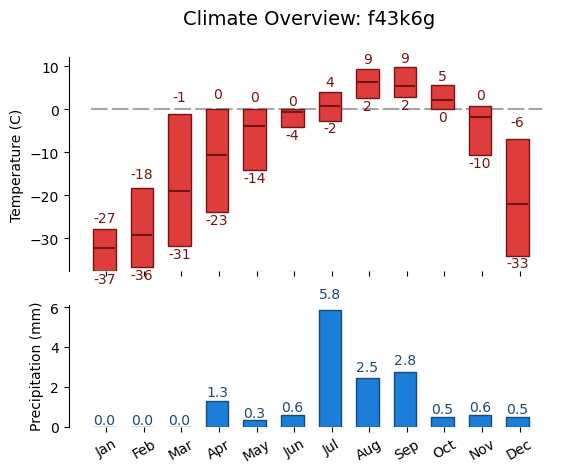

In [24]:
# data = np.loadtxt(fname=filename)
# data[:, 0] = data[:, 0] - 1
# data[:, 1] = converter(data[:, 1])
# data[:, 2] = converter(data[:, 2])
# if use_c == False:
#     data[:, 3] = data[:, 3] * 0.0393701
# data[:, 4] = converter(data[:, 4])

plt.ion()
plt.clf()
fig = plt.figure(1)
fig.subplots_adjust(hspace=.20)
gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

ax0.patch.set_facecolor('None')
ax1.patch.set_facecolor('None')

plt.suptitle('Climate Overview: ' + geohash, fontsize=14)

if mwd.map(lambda x: x[1]).min() < 5:
    y = 0 if use_c else c2f(0)
    ax0.plot([0, 12], [y, y], zorder=-1, color='#888888', alpha=.75, dashes=(8, 2))

#                      [0 .. 11]          temp_max - temp_min      temp_min
rects0 = ax0.bar(.35 + np.arange(0,12), mwd.map(lambda x: x[3]-x[1]).collect(), bottom=mwd.map(lambda x: x[1]).collect(),
        width=.6, color='#df3c3c', edgecolor='#731515')

#                      [0 .. 11]          precip
rects1 = ax1.bar(.35 + np.arange(0,12), mwd.map(lambda x: x[4]).collect(), color='#1b7edb', width=.6,
        edgecolor='#1d4871')

plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=30)

disable_spines(ax0)
disable_spines(ax1)
ax0.spines['left'].set_visible(True)
ax1.spines['left'].set_visible(True)

for tic in ax0.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax0.yaxis.get_major_ticks():
    tic.tick2On = False

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax1.yaxis.get_major_ticks():
    tic.tick2On = False

for rect in rects1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
        '%.1f' % (height), ha='center', va='bottom', color='#1d4871')

temp_avg = mwd.map(lambda x: x[2]).collect()
for r, rect in enumerate(rects0):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
        '%d' % int(height + rect.get_y()), ha='center', va='bottom',
        color='#731515')
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - .24,
        '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
    ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
            [temp_avg[r], temp_avg[r]], color='#731515')

if use_c:
    ax0.set_ylabel('Temperature (C)')
    ax1.set_ylabel('Precipitation (mm)')
else:
    ax0.set_ylabel('Temperature (F)')
    ax1.set_ylabel('Precipitation (in)')

In [25]:
print(timeit.default_timer()-start)

527.0752403259976
